## Voltage-based SOC estimation
This notebook implements two voltage-based SOC-estimation methods. The first one simply looks up cell terminal voltage under load in an OCV from SOC table. The second attempts to compensate for the effects of cell equivalent-series resistance.

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
model = scipy.io.loadmat('../data/CellModel.mat', simplify_cells=True)['model']

In [3]:
model.keys()

dict_keys(['name', 'OCV0', 'OCVrel', 'SOC', 'OCV', 'SOC0', 'SOCrel', 'dOCV0', 'dOCVrel', 'temps', 'QParam', 'RCParam', 'RParam', 'GParam', 'Z0Param', 'R0Param', 'MParam'])

In [4]:
data = scipy.io.loadmat('../data/CellData.mat', simplify_cells=True)

In [5]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'time', 'current', 'voltage', 'soc'])

**Create SOCfromOCVtemp & OCVfromSOCtemp functions**

This function returns the fully rested open-circuit-voltage of an LiPB
cell given its soc.
Syntax: ocv=OCVfromSOCtemp(soc,temp,model)
where soc is cell state of charge between 0 and 1,
temp is cell temperature in degrees celsius,
and model is a cell model structure.

In [6]:
def OCVfromSOCtemp(soc,temp,model):
    
    SOC = model['SOC']
    OCV0 = model['OCV0']
    OCVrel = model['OCVrel']
    
    OCVtemp = OCVrel*temp + OCV0
    y_interp = interp1d(SOC,OCVtemp,fill_value="extrapolate")
    
    return y_interp(soc)

In [7]:
def SOCfromOCVtemp(voltage,temp,model):
    
    SOC = model['SOC']
    OCV0 = model['OCV0']
    OCVrel = model['OCVrel']
    
    OCVtemp = OCVrel*temp + OCV0
    y_interp = interp1d(OCVtemp,SOC,fill_value="extrapolate")
    
    return y_interp(voltage)

In [8]:
temp = 25
soc = [0.5,1.0]
OCVfromSOCtemp(soc,temp,model)

array([3.97047401, 4.28463465])

In [9]:
temp = 25
voltage = [3.95,4.00]
SOCfromOCVtemp(voltage,temp,model)

array([0.45238723, 0.61883699])

### Estimating SOC based on OCV only

In [10]:
soc_true = data['soc']
voltage_true = data['voltage']

In [11]:
soc_estimate1 = SOCfromOCVtemp(voltage_true,25,model)

In [12]:
len(soc_estimate1)

28510

In [13]:
t = list(range(len(soc_estimate1)))

In [14]:
t = [t/60 for t in t]

Text(0.5, 1.0, 'True SOC and voltage-based estimate')

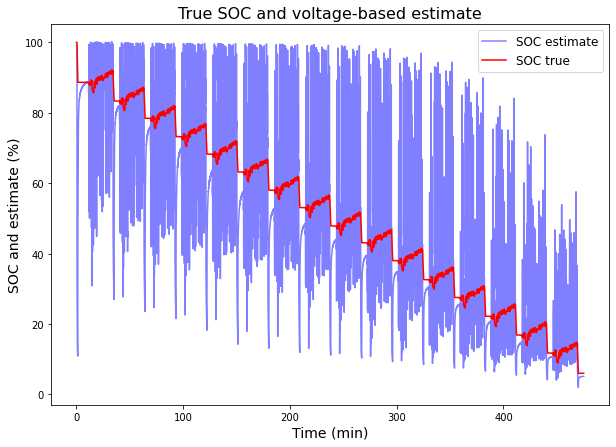

In [15]:
plt.figure(figsize=(10,7))
plt.plot(t,100*soc_estimate1,label='SOC estimate',color='blue',alpha=0.50)
plt.plot(t,100*soc_true,label='SOC true',color='red')
plt.ylabel('SOC and estimate (%)',fontsize=14)
plt.xlabel('Time (min)',fontsize=14)
plt.legend(fontsize=12,loc='upper right')
plt.title('True SOC and voltage-based estimate',fontsize=16)

In [16]:
rmse1 = np.sqrt(np.mean((soc_true-soc_estimate1)**2))
rmse1

0.14280350809942688

### Estimating SOC based on OCV, but also compensating for series resistance

In [17]:
params = dict()

for temp in model['temps']:
    params[temp] = dict()
    
for temp,r0 in zip(model['temps'],model['R0Param']):
    params[temp]['R0Param'] = r0

In [18]:
params

{-30: {'R0Param': 0.06511774706933018},
 -25: {'R0Param': 0.06176717568120656},
 -20: {'R0Param': 0.04557206751666927},
 -15: {'R0Param': 0.03376801682956661},
 -10: {'R0Param': 0.02412238582483068},
 -5: {'R0Param': 0.017331327629257084},
 0: {'R0Param': 0.01209861677113545},
 5: {'R0Param': 0.007928762175027115},
 10: {'R0Param': 0.005760371171211421},
 15: {'R0Param': 0.0042542796852019895},
 20: {'R0Param': 0.003228042850006448},
 25: {'R0Param': 0.0025432847542367167},
 30: {'R0Param': 0.0022118426035353444},
 35: {'R0Param': 0.0018908062441440573},
 40: {'R0Param': 0.0016619328710114707},
 45: {'R0Param': 0.0014892091405329056}}

In [19]:
temp = 25

R0 = params[temp]['R0Param']

In [20]:
R0

0.0025432847542367167

In [21]:
current_true = data['current']

In [22]:
soc_estimate2 = SOCfromOCVtemp(voltage_true+(current_true*R0),temp,model)

Text(0.5, 1.0, 'True SOC and voltage-based estimate')

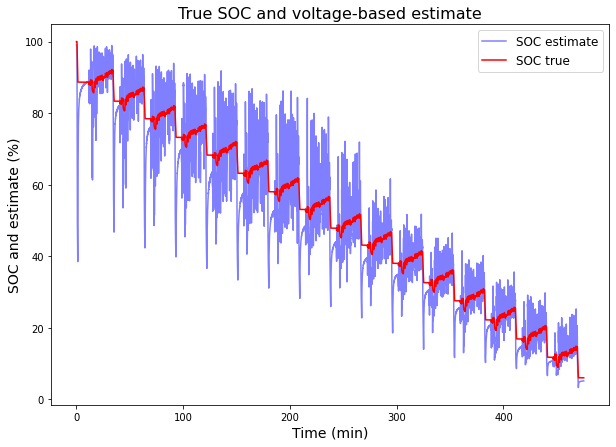

In [23]:
plt.figure(figsize=(10,7))
plt.plot(t,100*soc_estimate2,label='SOC estimate',color='blue',alpha=0.50)
plt.plot(t,100*soc_true,label='SOC true',color='red')
plt.ylabel('SOC and estimate (%)',fontsize=14)
plt.xlabel('Time (min)',fontsize=14)
plt.legend(fontsize=12,loc='upper right')
plt.title('True SOC and voltage-based estimate',fontsize=16)

In [25]:
rmse2 = np.sqrt(np.mean((soc_true-soc_estimate2)**2))
rmse2

0.07125495084663067